# ODSC East 2023

## Structured Multi-Class Classification with StructureBoost
StructureBoost can also be configured to exploit structure in the *target* variable for multi-class problems.

## How does it work?
- We can define structure based on a set of *partitions* of the state space.  Each partition represents a (meaningful) coarsening of the state space.  Then, when we compute the loss function (log-loss aka cross-entropy aka NLL), we compute it w.r.t. the coarsened state spaces as well as the original, and average the results.

By "the loss function wrt to the partition", what we mean is:

1. Take the predicted probability distribution for the particular test point
2. Convert it to a probability distribution on the coarsened state space by summing over the individual values in each coarsened state
3. Map the true answer to its respective coarsened state
4. Compute the log-loss of the coarsened probability distribution against the coarsened true answer

## Reference
"Loss Functions for Classification using Structured Entropy" B. Lucena - https://arxiv.org/abs/2206.07122

### Example

To represent the months of the year (where 1 = January, 2 = Feb, ... 12 = December), we might consider the partition:

$\mathcal{P}_1 = \{\{1,2,3\},\{4,5,6\},\{7,8,9\},\{10,11,12\}\}$

You could think of this as coarsening the months into seasons {winter, spring, summer, fall}.  Then we could use a loss function that is essentially 1/2 the *regular* log-loss and 1/2 log-loss with respect to the partition $\mathcal{P}_1$ above. The idea, is that this modified loss function will "reward" a prediction (penalize it less) for being "close" to the right answer (i.e. in the right season if not the right month).

To provide better symmetry, we could go further and define three partitions:

$\mathcal{P}_1 = \{\{1,2,3\},\{4,5,6\},\{7,8,9\},\{10,11,12\}\}$

$\mathcal{P}_2 = \{\{2,3,4\},\{5,6,7\},\{8,9,10\},\{11,12,1\}\}$

$\mathcal{P}_3 = \{\{3,4,5\},\{6,7,8\},\{9,10,11\},\{12,1,2\}\}$

and have the loss function be weighted .25 for each of the three partitions above and .25 for the standard log-loss.


## Imports, etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import structureboost as stb
import ml_insights as mli

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns',999)

In [2]:
df_ca = pd.read_csv('../data/ca_weather.csv')

## Load the Data and Explore
As you can see below, this is a dataset where each row represents the weather observations from a particular weather station on a particular date.  We know the min and max temperature (TMIN, TMAX), the amount of precipitation (PRCP), as well as the month of the observation and the county where the weather station is located.

California has 58 counties, however, the weather station in Sutter County does not record temperature, so for the purposes of this exercise we are combining Sutter and Yuba counties into a single county "Sutter_Yuba" so that there are 57 counties.  You can see below that we have selected 5000 observations from each of the 57 counties.

In [3]:
df_ca.shape


(285000, 7)

In [4]:
df_ca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285000 entries, 0 to 284999
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   county   285000 non-null  object 
 1   month    285000 non-null  int64  
 2   PRCP     285000 non-null  float64
 3   TMAX     285000 non-null  float64
 4   TMIN     285000 non-null  float64
 5   DATE     285000 non-null  object 
 6   STATION  285000 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 15.2+ MB


In [5]:
df_ca.sample(5)

,county,month,PRCP,TMAX,TMIN,DATE,STATION
247919,Stanislaus,3,0.0,65.0,41.0,2015-03-03,USW00023258
116715,Merced,6,0.0,91.0,56.0,2004-06-18,USC00046168
63540,Imperial,5,0.0,84.0,53.0,2000-05-12,USC00041048
209758,Santa_Barbara,1,0.0,73.0,40.0,2014-01-12,USW00053152
196014,San_Luis_Obispo,1,0.0,59.0,41.0,2011-01-05,USC00043882


In [6]:
df_ca.county.value_counts()

Alameda            5000
Orange             5000
Plumas             5000
Riverside          5000
Sacramento         5000
San_Benito         5000
San_Bernardino     5000
San_Diego          5000
San_Francisco      5000
San_Joaquin        5000
San_Luis_Obispo    5000
San_Mateo          5000
Santa_Barbara      5000
Santa_Clara        5000
Santa_Cruz         5000
Shasta             5000
Sierra             5000
Siskiyou           5000
Solano             5000
Sonoma             5000
Stanislaus         5000
Tehama             5000
Trinity            5000
Tulare             5000
Tuolumne           5000
Ventura            5000
Yolo               5000
Placer             5000
Nevada             5000
Alpine             5000
Napa               5000
Amador             5000
Butte              5000
Calaveras          5000
Colusa             5000
Contra_Costa       5000
Del_Norte          5000
El_Dorado          5000
Fresno             5000
Glenn              5000
Humboldt           5000
Imperial        

In [7]:
df_ca.month.value_counts()

5     24772
3     24648
1     24610
7     24416
8     24031
4     23688
10    23673
6     23324
12    23317
9     23063
2     22778
11    22680
Name: month, dtype: int64

## Goal
First, we are going to build a model that tries to predict the month of the year, given the min and max temperature (TMIN, TMAX) and the amount of precipitation (PRCP).  In general, we don't expect to be able to predict the month exactly, but we would like to have an accurate probability distribution on what month it is given the temperatures and precipitation that day.  Thus we will use the `log_loss` to determine the quality of our predictions.

Clearly, there is some meaningful *structure* in the target variable month.  We expect the weather in January to be more similar to December than it is to July.  Thus, it is reasonable to expect that we will get better performance if the model is aware of these similarities during training, rather than just knowing that months are different from one another.


In [8]:
np.unique(df_ca.month)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

As would be expected, the months are numbered 1 through 12.  StructureBoost requires the target to be integers from 0 to num_classes-1.  Thus, we will create a modified "month" variable where December (12) is designated as 0.

In [9]:
tvec = df_ca['month'].copy()
tvec[tvec==12] = 0
df_ca['month_mod'] = tvec

In [10]:
np.unique(df_ca.month_mod)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

Now we'll split the data into training, validation, and test_folds

In [11]:
feat_list = ['TMAX','TMIN','PRCP']
target = 'month_mod'

X = df_ca.loc[:,feat_list]
y = df_ca[target]


In [12]:
# Here we can configure the sizes of our training, validation and test sets (and the rest will be a "remainder")
train_size = 1000
valid_size = 5000
test_size = 100000

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=test_size, random_state=42)
X_train_rem, X_valid, y_train_rem, y_valid = train_test_split(X_train_val, y_train_val, test_size=valid_size, random_state=42)
X_train, X_rem, y_train, y_rem = train_test_split(X_train_rem, y_train_rem, train_size=train_size, random_state=42)
X_train.shape, X_valid.shape, X_test.shape, X_rem.shape


((1000, 3), (5000, 3), (100000, 3), (179000, 3))

## Configuring StructureBoost Target Structure

StructureBoost permits two methods for defining the structure on a target variable:

    1. Using a fixed set of partitions (with corresponding weights)
    2. Using a graph, and randomly choosing partitions from the graph.

The idea is that the partitions provide meaningful "coarsenings" of the target state space.  The loss function, will then be able to take into account that values in the same *block* of the partition are similar.  The beauty of this approach is that we can use many partitions at the same time.

For example, for the months of the year, one might consider that the months of each season tend to have similar weather.  This might lead us to define a partition of the months such as:
{Dec, Jan, Feb}, {Mar, Apr, May}, {Jun, Jul, Aug}, {Sep, Oct, Nov}

In [13]:
# This is a quick way to get a starting feature configuration that can be modified
fc1 = stb.get_basic_config(X_train, stb.default_config_dict())
fc1

{'TMAX': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'TMIN': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'PRCP': {'feature_type': 'numerical', 'max_splits_to_search': 25}}

First we will run StructureBoost with no knowledge of the structure of the months.

In [14]:
# Define the StructureBoost model and fit it
stb0 = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, 
                               target_structure=None, learning_rate=.02)
stb0.fit(X_train,y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=1, eval_freq=10)

i=0, eval_set_loss = 2.489849939705327
i=10, eval_set_loss = 2.3884196633392474
i=20, eval_set_loss = 2.322368753971069
i=30, eval_set_loss = 2.275322472148718
i=40, eval_set_loss = 2.2419969916111433
i=50, eval_set_loss = 2.2192446740611618
i=60, eval_set_loss = 2.2027085089538305
i=70, eval_set_loss = 2.190164327510415
i=80, eval_set_loss = 2.18113555307066
i=90, eval_set_loss = 2.174714222070104
i=100, eval_set_loss = 2.1696721915016304
i=110, eval_set_loss = 2.1666685108640182
i=120, eval_set_loss = 2.164678585512138
i=130, eval_set_loss = 2.1627868359012843
i=140, eval_set_loss = 2.1608460992902523
i=150, eval_set_loss = 2.1605391618685457
i=160, eval_set_loss = 2.160530790168717
i=170, eval_set_loss = 2.161747254850028
Stopping early: low pt was 1 steps ago


In [15]:
# Make predictions on a test set, and then evaluate the log_loss
test_preds_0 = stb0.predict_proba(X_test)
log_loss(y_test, test_preds_0)

2.1527500631825593

Next, we will configure StructureBoost using a fixed set of partitions.  We will group the months in "blocks" of size 3 - and there are 3 different partitions, depending on where we start grouping.

StructureBoost assumes you will always use the singleton partition as part of the partition set.  We give a weight using the `singleton_weight` parameter.

The weights for the other partitions in the partition set must be designated by the `partition_weight_vec` parameter.  The weights should sum to 1.  (you will get a warning, but not an error, if this is not the case).

In the example below, the singleton partition has weight 0.4 and the other 3 partitions each have weight 0.2.

In [16]:
# Here we configure the target structure to use a fixed, weighted partition
ts1 = {}
ts1['partition_type'] = 'fixed'
ts1['singleton_weight'] = .4
ts1['partition_list'] = [ [[0,1,2],[3,4,5],[6,7,8],[9,10,11]],
                         [[1,2,3],[4,5,6],[7,8,9],[10,11,0]],
                         [[2,3,4],[5,6,7],[8,9,10],[11,0,1]] ]
ts1['partition_weight_vec'] = [.2,.2,.2]

In [17]:
# Define the StructureBoost model and fit it
stb1 = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, 
                               target_structure=ts1, learning_rate=.02)

stb1.fit(X_train,y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=1, eval_freq=10)

i=0, eval_set_loss = 2.489849939705327
i=10, eval_set_loss = 2.4074170814726896
i=20, eval_set_loss = 2.3456184600913375
i=30, eval_set_loss = 2.2983944303329698
i=40, eval_set_loss = 2.2625833127760626
i=50, eval_set_loss = 2.2352427711725946
i=60, eval_set_loss = 2.214381378899011
i=70, eval_set_loss = 2.1986015362190217
i=80, eval_set_loss = 2.1869802418291147
i=90, eval_set_loss = 2.177276202039077
i=100, eval_set_loss = 2.1701037672262533
i=110, eval_set_loss = 2.164311074172783
i=120, eval_set_loss = 2.1600087413195004
i=130, eval_set_loss = 2.156338585319163
i=140, eval_set_loss = 2.153754041605966
i=150, eval_set_loss = 2.1525315267597303
i=160, eval_set_loss = 2.1515092681828296
i=170, eval_set_loss = 2.150409643388331
i=180, eval_set_loss = 2.1500623782939625
i=190, eval_set_loss = 2.14990990197078
i=200, eval_set_loss = 2.1494901884730147
i=210, eval_set_loss = 2.149878418314159
Stopping early: low pt was 1 steps ago


In [18]:
# Make predictions on a test set, and then evaluate the log_loss
test_preds_1 = stb1.predict_proba(X_test)
log_loss(y_test, test_preds_1)

2.1395865042260156

In some cases it may be tedious to write out a fixed partition.  There is an alternative, when the desired structure can be represented in terms of a *graph*.  In this case we can simply provide the graph and ask StructureBoost to randomly find partitions of the graph (which respect the structure of the graph).  Then, at each iteration, a different, randomly chosen partition (or partitions) of the graph will be used, in conjunction with the singleton partition.

We show how to configure this below.

In [19]:
# First we must define the appropriate graph
cycle_0_11 = stb.graphs.cycle_int_graph(0,11)
cycle_0_11.vertices, cycle_0_11.edges

({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11},
 {frozenset({3, 4}),
  frozenset({2, 3}),
  frozenset({9, 10}),
  frozenset({1, 2}),
  frozenset({4, 5}),
  frozenset({0, 1}),
  frozenset({6, 7}),
  frozenset({8, 9}),
  frozenset({7, 8}),
  frozenset({5, 6}),
  frozenset({0, 11}),
  frozenset({10, 11})})

In [20]:
# Here we configure the target structure to use a variable (random) partition
# We must specify how many partitions we want, and of what sizes
# Note: partition size refers to the *number* of blocks, not the size of the blocks

ts2a = {}
ts2a['partition_type'] = 'variable'
ts2a['target_graph'] = cycle_0_11
ts2a['singleton_weight'] = .5
ts2a['num_partitions'] = 1
ts2a['random_partition_size'] = 4

In [21]:
stb2a = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, 
                               target_structure=ts2a, learning_rate=.02)

stb2a.fit(X_train,y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=1, eval_freq=10)

'rp_method' not configured. Defaulting to 'span_tree'
i=0, eval_set_loss = 2.489849939705327
i=10, eval_set_loss = 2.405771609056623
i=20, eval_set_loss = 2.3433262249015496
i=30, eval_set_loss = 2.2975031282108698
i=40, eval_set_loss = 2.262498926178384
i=50, eval_set_loss = 2.236777312537504
i=60, eval_set_loss = 2.2179757750634037
i=70, eval_set_loss = 2.202672303653494
i=80, eval_set_loss = 2.191237466318734
i=90, eval_set_loss = 2.183490316818054
i=100, eval_set_loss = 2.1771306126051115
i=110, eval_set_loss = 2.1721759168055614
i=120, eval_set_loss = 2.168550411776606
i=130, eval_set_loss = 2.1652958918025726
i=140, eval_set_loss = 2.1629923045385824
i=150, eval_set_loss = 2.1613967305638915
i=160, eval_set_loss = 2.160235309313727
i=170, eval_set_loss = 2.1589189924532017
i=180, eval_set_loss = 2.1584967188659188
i=190, eval_set_loss = 2.158930036855371
Stopping early: low pt was 1 steps ago


In [22]:
# Make predictions on a test set, and then evaluate the log_loss
test_preds_2a = stb2a.predict_proba(X_test)
log_loss(y_test, test_preds_2a)

2.1495198467292744

In [23]:
# This time, let's configure it so that there are multiple partitions, of various sizes
# Each partition is given the same weight (= (1-singleton_weight)/num_partitions))
ts2b = {}
ts2b['partition_type'] = 'variable'
ts2b['target_graph'] = cycle_0_11
ts2b['singleton_weight'] = .5
ts2b['num_partitions'] = 5
ts2b['random_partition_size'] = [3,3,4,5,6]

In [24]:
stb2b = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, 
                               target_structure=ts2b, learning_rate=.02)

stb2b.fit(X_train,y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=1, eval_freq=10)

'rp_method' not configured. Defaulting to 'span_tree'
i=0, eval_set_loss = 2.489849939705327
i=10, eval_set_loss = 2.4061026783731227
i=20, eval_set_loss = 2.3412108300292274
i=30, eval_set_loss = 2.2942013416669904
i=40, eval_set_loss = 2.2591424779511864
i=50, eval_set_loss = 2.233158011287026
i=60, eval_set_loss = 2.2146891462461857
i=70, eval_set_loss = 2.1998586816300314
i=80, eval_set_loss = 2.189831978624628
i=90, eval_set_loss = 2.1816492529694704
i=100, eval_set_loss = 2.1756005860712966
i=110, eval_set_loss = 2.170611975780467
i=120, eval_set_loss = 2.1662806106936237
i=130, eval_set_loss = 2.163253027020815
i=140, eval_set_loss = 2.1606888418733163
i=150, eval_set_loss = 2.1590248233357885
i=160, eval_set_loss = 2.1582995249388
i=170, eval_set_loss = 2.1573666388127903
i=180, eval_set_loss = 2.1566859432867425
i=190, eval_set_loss = 2.1561759330232513
i=200, eval_set_loss = 2.156974816572876
Stopping early: low pt was 1 steps ago


In [25]:
# Make predictions on a test set, and then evaluate the log_loss
test_preds_2b = stb2b.predict_proba(X_test)
log_loss(y_test, test_preds_2b)

2.146004210412635

## Predicting the County

In [26]:
ca_county_graph_mod = stb.graphs.mod_CA_57_county_graph()
county_graph_int, map_dict = stb.graphs.integerize_graph(ca_county_graph_mod)
df_ca['county_int'] = df_ca.county.apply(lambda x: map_dict[x])

In [27]:
month_graph = stb.graphs.cycle_int_graph(1,12)
month_graph.edges

{frozenset({3, 4}),
 frozenset({2, 3}),
 frozenset({11, 12}),
 frozenset({9, 10}),
 frozenset({1, 2}),
 frozenset({4, 5}),
 frozenset({6, 7}),
 frozenset({8, 9}),
 frozenset({7, 8}),
 frozenset({1, 12}),
 frozenset({5, 6}),
 frozenset({10, 11})}

In [28]:
feat_list = ['TMAX','TMIN','PRCP','month']
target = 'county_int'

X = df_ca.loc[:,feat_list]
y = df_ca[target]

In [29]:
# Here we can configure the sizes of our training, validation and test sets (and the rest will be a "remainder")
train_size = 1000
valid_size = 5000
test_size = 100000

X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=test_size, random_state=42)
X_train_rem, X_valid, y_train_rem, y_valid = train_test_split(X_train_val, y_train_val, test_size=valid_size, random_state=42)
X_train, X_rem, y_train, y_rem = train_test_split(X_train_rem, y_train_rem, train_size=train_size, random_state=42)
X_train.shape, X_valid.shape, X_test.shape, X_rem.shape


((1000, 4), (5000, 4), (100000, 4), (179000, 4))

In [30]:
# This is a quick way to get a starting feature configuration that can be modified
fc2 = stb.get_basic_config(X_train, stb.default_config_dict())
fc2['month']['feature_type'] = 'categorical_int'
fc2['month']['graph'] = month_graph
fc2['month']['split_method'] = 'span_tree'
fc2['month']['num_span_trees']=1
fc2   

{'TMAX': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'TMIN': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'PRCP': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'month': {'feature_type': 'categorical_int',
  'max_splits_to_search': 25,
  'graph': <structureboost.graphs.graph_undirected at 0x1411e4400>,
  'split_method': 'span_tree',
  'num_span_trees': 1}}

In [31]:
ts3 = {}
ts3['partition_type'] = 'variable'
ts3['target_graph'] = county_graph_int
ts3['singleton_weight'] = .2
ts3['num_partitions'] = 5
ts3['random_partition_size'] = [5,8,10,15,20]

In [32]:
stb3 = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc2, num_classes=57, 
                               target_structure=ts3, learning_rate=.02)

stb3.fit(X_train,y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=1, eval_freq=10)

'rp_method' not configured. Defaulting to 'span_tree'
i=0, eval_set_loss = 4.0889686351661485
i=10, eval_set_loss = 4.063568180644464
i=20, eval_set_loss = 4.038308379275456
i=30, eval_set_loss = 4.016133697484174
i=40, eval_set_loss = 3.9959439966822714
i=50, eval_set_loss = 3.978769895690585
i=60, eval_set_loss = 3.9633561021128187
i=70, eval_set_loss = 3.9496274215407197
i=80, eval_set_loss = 3.9380219362631776
i=90, eval_set_loss = 3.924699970963618
i=100, eval_set_loss = 3.9137158464394366
i=110, eval_set_loss = 3.904964749884044
i=120, eval_set_loss = 3.894948576397307
i=130, eval_set_loss = 3.8855439411816994
i=140, eval_set_loss = 3.878876754083528
i=150, eval_set_loss = 3.869417199305966
i=160, eval_set_loss = 3.8627940770592177
i=170, eval_set_loss = 3.8564428786408027
i=180, eval_set_loss = 3.851188082129262
i=190, eval_set_loss = 3.847041941220462
i=200, eval_set_loss = 3.841966805561041
i=210, eval_set_loss = 3.8381468089379385
i=220, eval_set_loss = 3.8332806996379527
i=2

In [33]:
test_preds_a = stb3.predict_proba(X_test)
log_loss(y_test, test_preds_a)

3.8021056146322105

In [34]:
# This is a quick way to get a starting feature configuration that can be modified
fc2 = stb.get_basic_config(X_train, stb.default_config_dict())
fc2['month']['feature_type'] = 'categorical_int'
fc2['month']['graph'] = month_graph
fc2['month']['split_method'] = 'span_tree'
fc2['month']['num_span_trees']=1
fc2   

{'TMAX': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'TMIN': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'PRCP': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'month': {'feature_type': 'categorical_int',
  'max_splits_to_search': 25,
  'graph': <structureboost.graphs.graph_undirected at 0x1411e4400>,
  'split_method': 'span_tree',
  'num_span_trees': 1}}

In [35]:
stb4 = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc2, num_classes=57, 
                               target_structure=None, learning_rate=.02)
stb4.fit(X_train,y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=1, eval_freq=10)

i=0, eval_set_loss = 4.0889686351661485
i=10, eval_set_loss = 4.032173541847412
i=20, eval_set_loss = 3.989135091619825
i=30, eval_set_loss = 3.956842941820463
i=40, eval_set_loss = 3.9334231408392233
i=50, eval_set_loss = 3.9136416495730484
i=60, eval_set_loss = 3.8996468535415296
i=70, eval_set_loss = 3.886081408100595
i=80, eval_set_loss = 3.874749983049261
i=90, eval_set_loss = 3.8660423233456007
i=100, eval_set_loss = 3.8601252012606055
i=110, eval_set_loss = 3.8534086501429754
i=120, eval_set_loss = 3.8497842739133556
i=130, eval_set_loss = 3.8470099327823046
i=140, eval_set_loss = 3.8446644320370877
i=150, eval_set_loss = 3.8417472322929354
i=160, eval_set_loss = 3.8415231131179657
i=170, eval_set_loss = 3.8401682933422094
i=180, eval_set_loss = 3.839671345308125
i=190, eval_set_loss = 3.8390036173899307
i=200, eval_set_loss = 3.841432950965505
Stopping early: low pt was 1 steps ago


In [36]:
test_preds_b = stb4.predict_proba(X_test)
log_loss(y_test, test_preds_b)

3.8382815172922826

# Wrap-up

- ### Check out / Subscribe to my YouTube channel: https://www.youtube.com/numeristical
- ### Please rate this talk on the ODSC app!
- ### If you find the structureboost package useful, please give it a star on Github!
- ### Questions or problems with StructureBoost - email me: brian@numeristical.com
- ### Make an account at www.numeristical.com to be added to Slack / Discord
- ### Thanks!

## Rigorous testing, Varying the singleton weight
Let's see how this does as we vary the singleton weight from 0.0 to 1.0: Note that a singleton weight of 0 is not recommended, as it means there is no "incentive" to get the month exactly right.  A singleton weight of 1 means that we are not using the structure at all - it is equivalent to setting `target_structure=None` (using a classical approach to multi-classification).

In [37]:
feat_list = ['TMAX','TMIN','PRCP']
target = 'month_mod'

X = df_ca.loc[:,feat_list]
y = df_ca[target]


In [38]:
train_size = 5000
valid_size = 5000
test_size = 100000
num_trials= 5
sw_vec = np.arange(0,11)/10

ll_mat = np.zeros((num_trials, len(sw_vec)))
acc_mat = np.zeros((num_trials, len(sw_vec)))


for tr in range(num_trials):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=test_size, random_state=tr)
    X_train_rem, X_valid, y_train_rem, y_valid = train_test_split(X_train_val, y_train_val, test_size=valid_size, random_state=tr)
    X_train, X_rem, y_train, y_rem = train_test_split(X_train_rem, y_train_rem, train_size=train_size, random_state=tr)




    for i,sw in enumerate(sw_vec):
        print('Singleton weight = {}'.format(sw))
        print('trial_number = {}'.format(tr))
        ts = {}
        ts['partition_type'] = 'fixed'
        ts['partition_list'] = [ [[0,1,2],[3,4,5],[6,7,8],[9,10,11]],
                                 [[1,2,3],[4,5,6],[7,8,9],[10,11,0]],
                                 [[2,3,4],[5,6,7],[8,9,10],[11,0,1]] ]
        ts['singleton_weight'] = sw
        rem = (1-sw)/3
        ts['partition_weight_vec'] = [rem, rem, rem]
        stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)
        stb_tmp.fit(X_train,y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=1, eval_freq=10)
        preds_tmp = stb_tmp.predict_proba(X_test)
        ll = log_loss(y_test, preds_tmp)
        hard_preds = np.argmax(preds_tmp,axis=1)
        acc = accuracy_score(y_test,hard_preds)
        ll_mat[tr,i] = ll
        acc_mat[tr,i] = acc

Singleton weight = 0.0
trial_number = 0
i=0, eval_set_loss = 2.484818205015985
i=10, eval_set_loss = 2.409490049215739
i=20, eval_set_loss = 2.3497469576917718
i=30, eval_set_loss = 2.3028450308820516
i=40, eval_set_loss = 2.2660609039167015
i=50, eval_set_loss = 2.237433191861029
i=60, eval_set_loss = 2.214647789315113
i=70, eval_set_loss = 2.19700127060604
i=80, eval_set_loss = 2.1830250983114916
i=90, eval_set_loss = 2.172166079180065
i=100, eval_set_loss = 2.163166416674589
i=110, eval_set_loss = 2.155966652566389
i=120, eval_set_loss = 2.1497897944724524
i=130, eval_set_loss = 2.1451283694053274
i=140, eval_set_loss = 2.1410607999773594
i=150, eval_set_loss = 2.1374833218216556
i=160, eval_set_loss = 2.1342602313635894
i=170, eval_set_loss = 2.1316000447400274
i=180, eval_set_loss = 2.1294282181456334
i=190, eval_set_loss = 2.127671283491494
i=200, eval_set_loss = 2.1258052504465117
i=210, eval_set_loss = 2.1243269658913335
i=220, eval_set_loss = 2.1228845942883905
i=230, eval_set

/var/folders/q8/xr46tkk15h10554_3mptdjlw0000gn/T/ipykernel_69382/1669956703.py:30: UserWarning: Some weights are not positive - may cause unexpected results
  stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)


i=10, eval_set_loss = 2.3764721138727674
i=20, eval_set_loss = 2.3045167976313636
i=30, eval_set_loss = 2.2541800249178583
i=40, eval_set_loss = 2.218643987355706
i=50, eval_set_loss = 2.1924362588257162
i=60, eval_set_loss = 2.1727296223197654
i=70, eval_set_loss = 2.1585284608003876
i=80, eval_set_loss = 2.147462256389585
i=90, eval_set_loss = 2.139483920341072
i=100, eval_set_loss = 2.1329496173955538
i=110, eval_set_loss = 2.127863463706511
i=120, eval_set_loss = 2.1239894382831963
i=130, eval_set_loss = 2.1215178324017097
i=140, eval_set_loss = 2.1193030105320765
i=150, eval_set_loss = 2.11778738195568
i=160, eval_set_loss = 2.1165479947390704
i=170, eval_set_loss = 2.115748552023726
i=180, eval_set_loss = 2.115072352299674
i=190, eval_set_loss = 2.114267761205646
i=200, eval_set_loss = 2.113773219294686
i=210, eval_set_loss = 2.1134286561306146
i=220, eval_set_loss = 2.1130879720416997
i=230, eval_set_loss = 2.1128826615382006
i=240, eval_set_loss = 2.112803165169477
i=250, eval_

/var/folders/q8/xr46tkk15h10554_3mptdjlw0000gn/T/ipykernel_69382/1669956703.py:30: UserWarning: Some weights are not positive - may cause unexpected results
  stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)


i=20, eval_set_loss = 2.3030221092023897
i=30, eval_set_loss = 2.252984673754844
i=40, eval_set_loss = 2.2166265123095203
i=50, eval_set_loss = 2.190193251154391
i=60, eval_set_loss = 2.1702537177163403
i=70, eval_set_loss = 2.155117124866058
i=80, eval_set_loss = 2.143979946089514
i=90, eval_set_loss = 2.135104124364489
i=100, eval_set_loss = 2.128507591704978
i=110, eval_set_loss = 2.1228850327427478
i=120, eval_set_loss = 2.1188824980002066
i=130, eval_set_loss = 2.1156490790889797
i=140, eval_set_loss = 2.113197307112816
i=150, eval_set_loss = 2.111030635285728
i=160, eval_set_loss = 2.109512133197001
i=170, eval_set_loss = 2.1082839604063035
i=180, eval_set_loss = 2.1070091050889497
i=190, eval_set_loss = 2.106496200181173
i=200, eval_set_loss = 2.106016873740768
i=210, eval_set_loss = 2.105793609591228
i=220, eval_set_loss = 2.105723820433156
i=230, eval_set_loss = 2.1054794960822365
i=240, eval_set_loss = 2.1051854245519594
i=250, eval_set_loss = 2.1050460006714253
i=260, eval_s

/var/folders/q8/xr46tkk15h10554_3mptdjlw0000gn/T/ipykernel_69382/1669956703.py:30: UserWarning: Some weights are not positive - may cause unexpected results
  stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)


i=20, eval_set_loss = 2.3060479327948533
i=30, eval_set_loss = 2.2562634077424337
i=40, eval_set_loss = 2.2197442289240654
i=50, eval_set_loss = 2.192788830067317
i=60, eval_set_loss = 2.1726811223734868
i=70, eval_set_loss = 2.1581929468075223
i=80, eval_set_loss = 2.1471154021835543
i=90, eval_set_loss = 2.1384734762635222
i=100, eval_set_loss = 2.1315141254260395
i=110, eval_set_loss = 2.1264903582916594
i=120, eval_set_loss = 2.1224187851068645
i=130, eval_set_loss = 2.118829043796359
i=140, eval_set_loss = 2.1161125032672774
i=150, eval_set_loss = 2.1145645352672857
i=160, eval_set_loss = 2.1132234666189214
i=170, eval_set_loss = 2.111824963434555
i=180, eval_set_loss = 2.110598469586526
i=190, eval_set_loss = 2.1097139992538496
i=200, eval_set_loss = 2.1091908035991573
i=210, eval_set_loss = 2.108738898402764
i=220, eval_set_loss = 2.108220546853818
i=230, eval_set_loss = 2.1074908127549596
i=240, eval_set_loss = 2.107267027225758
i=250, eval_set_loss = 2.107092169056518
i=260, e

/var/folders/q8/xr46tkk15h10554_3mptdjlw0000gn/T/ipykernel_69382/1669956703.py:30: UserWarning: Some weights are not positive - may cause unexpected results
  stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)


i=20, eval_set_loss = 2.3068820196515167
i=30, eval_set_loss = 2.258517331379731
i=40, eval_set_loss = 2.2233525637069014
i=50, eval_set_loss = 2.1971995967283324
i=60, eval_set_loss = 2.1778031703414946
i=70, eval_set_loss = 2.163578213069157
i=80, eval_set_loss = 2.1522911832715166
i=90, eval_set_loss = 2.1436949596587835
i=100, eval_set_loss = 2.1369918581321135
i=110, eval_set_loss = 2.132014481201893
i=120, eval_set_loss = 2.128104488816377
i=130, eval_set_loss = 2.125708692077443
i=140, eval_set_loss = 2.1233872872689425
i=150, eval_set_loss = 2.121266219522249
i=160, eval_set_loss = 2.120181561898861
i=170, eval_set_loss = 2.119187397581677
i=180, eval_set_loss = 2.118407996089765
i=190, eval_set_loss = 2.1175305431547806
i=200, eval_set_loss = 2.1169719970662415
i=210, eval_set_loss = 2.116313942030784
i=220, eval_set_loss = 2.1159451390296913
i=230, eval_set_loss = 2.115849794182547
i=240, eval_set_loss = 2.115782483281479
i=250, eval_set_loss = 2.1156520527313583
i=260, eval_

/var/folders/q8/xr46tkk15h10554_3mptdjlw0000gn/T/ipykernel_69382/1669956703.py:30: UserWarning: Some weights are not positive - may cause unexpected results
  stb_tmp = stb.StructureBoostMulti(num_trees=2000, feature_configs=fc1, num_classes=12, target_structure=ts, learning_rate=.02)


i=20, eval_set_loss = 2.3026085729280115
i=30, eval_set_loss = 2.252026045087063
i=40, eval_set_loss = 2.2168805258461797
i=50, eval_set_loss = 2.1901926794147335
i=60, eval_set_loss = 2.171034739566681
i=70, eval_set_loss = 2.156376001740362
i=80, eval_set_loss = 2.1452882705434835
i=90, eval_set_loss = 2.1368786030318145
i=100, eval_set_loss = 2.1306269111266904
i=110, eval_set_loss = 2.1261232994766566
i=120, eval_set_loss = 2.1225302331833475
i=130, eval_set_loss = 2.1198203597164524
i=140, eval_set_loss = 2.1175672782529036
i=150, eval_set_loss = 2.1156332944438536
i=160, eval_set_loss = 2.1146675913332595
i=170, eval_set_loss = 2.113552348910132
i=180, eval_set_loss = 2.1128886041863186
i=190, eval_set_loss = 2.1124856958932314
i=200, eval_set_loss = 2.111773343457935
i=210, eval_set_loss = 2.1115818895417084
i=220, eval_set_loss = 2.1115740042918185
i=230, eval_set_loss = 2.1114244373536226
i=240, eval_set_loss = 2.1114865558242366
Stopping early: low pt was 1 steps ago


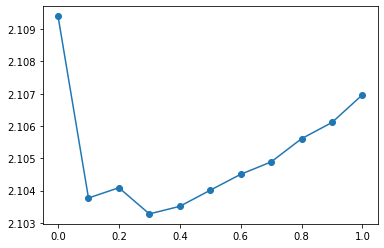

In [39]:
ll_vec = np.mean(ll_mat, axis=0)
plt.plot(sw_vec, ll_vec, marker='o')

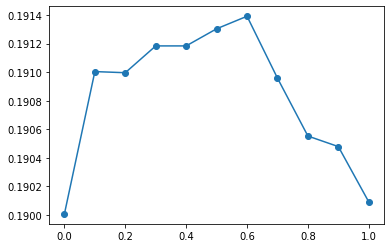

In [40]:
acc_vec = np.mean(acc_mat, axis=0)
plt.plot(sw_vec, acc_vec, marker='o')